# Link prediction on the Dbpedia graph

This notebook demonstrates how to perform the link prediction task on the Dbpedia graph dataset. The goal is to predict connections between scientists in the Dbpedia knowledge graph. To do this, the task is divided into two steps: 

1.   data collection and preprocessing, where data is collected from Dbpedia using SPARQL and cleaned and visualized before creating the final graph, and
2.   prediction, where a Graph Neural Network called GraphSAGE is used to predict the probability of two nodes being connected on the existing network. 

In order to use GraphSAGE, each node in the graph of scientists must have features that describe the corresponding scientist, such as their academic disciplines. Therefore, a second query is needed to obtain a dataframe of these features and align them with the corresponding nodes. As the graph includes labeled nodes, the link prediction task is treated as a supervised problem.

# Data acquisition - graph construction

The GNN model will be trained and tested on a dataset of scientists from the Dbpedia knowledge graph, which is collected using the SPARQL query language. To create the graph, a file containing the names of connected scientists is created using the **dbo:doctoralAdvisor | dbp:doctoralAdvisor** property, which indicates that one scientist served as the doctoral advisor of the other. In addition, a table of academic disciplines is created, which lists the academic disciplines associated with each scientist.

In [433]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import urllib
%matplotlib inline

In [434]:
for i in range(5):
    query = f"""
        select ?scientist_name1 ?scientist_name2
        where {{
            select distinct ?scientist_name1 ?scientist_name2
            where {{
                ?scientist1 dbo:doctoralAdvisor | dbp:doctoralAdvisor ?scientist2 .
                
                ?scientist1 rdfs:label ?scientist_name1 ;
                         dbo:academicDiscipline ?discipline1 .

                ?scientist2 rdfs:label ?scientist_name2 ;
                         dbo:academicDiscipline ?discipline2 .

                filter(lang(?scientist_name1)="en")
                filter(lang(?scientist_name2)="en")
            }}
            order by ?scientist_name1
        }}
        offset {i * 5000}
        limit 5000
    """
    endpoint = "http://dbpedia.org/sparql"

    param = urllib.parse.urlencode({'default-graph-uri': 'http://dbpedia.org', 
                                    'query': query, 
                                    'format': 'text/csv'})
    data = pd.read_csv(endpoint + '?' + param)
    data.to_csv(r"C:\Users\user\Desktop\GNNs\dbpedia\graph{}".format(i+1), index=False)

In [435]:
for i in range(6):
    query = f"""
        select ?scientist_name ?discipline
        where {{
            select distinct ?scientist_name ?discipline
            where {{
                {{
                    ?sbj dbo:Scientist ?scientist .
                }} union {{
                    ?scientist dbo:doctoralAdvisor | dbp:doctoralAdvisor ?obj .
                }} union {{
                    ?sbj1 dbo:doctoralAdvisor | dbp:doctoralAdvisor ?scientist .
                }}
                ?scientist rdfs:label ?scientist_name .

                ?scientist dbo:academicDiscipline ?discipline_uri .
                ?discipline_uri rdfs:label ?discipline .

                filter(lang(?discipline)="en")
                filter(lang(?scientist_name)="en")
            }}
            order by ?scientist_name
        }}
        offset {i * 5000}
        limit 5000
    """
    endpoint = "http://dbpedia.org/sparql"

    param = urllib.parse.urlencode({'default-graph-uri': 'http://dbpedia.org', 
                                    'query': query, 
                                    'format': 'text/csv'})
    data = pd.read_csv(endpoint + '?' + param)
    data.to_csv(r"C:\Users\user\Desktop\GNNs\dbpedia\discipline{}".format(i+1), index=False)

From the obtained files of the two SPARQL queries create the two dataframes: edge dataframe and disciplines dataframe

In [436]:
dl = list()
for i in range(5):
    dl.append(pd.read_csv(r"C:\Users\user\Desktop\GNNs\dbpedia\graph{}".format(i+1)))
edge_df = pd.concat(dl)
edge_df.sort_values(['scientist_name1', 'scientist_name2'], inplace=True, kind='mergesort')
edge_df.reset_index(inplace=True)
edge_df.drop(columns=['index'], inplace=True)
display(edge_df)

,scientist_name1,scientist_name2
0,A. David Buckingham,John Pople
1,A. J. Bernheim Brush,Alan H. Borning
2,A. Richard Newton,Donald Pederson
3,A. Rod Gover,Michael Eastwood
4,A. Ronald Gallant,Wayne Fuller
...,...,...
5106,Émile Lemoine,Charles Adolphe Wurtz
5107,Étienne Biéler,James Chadwick
5108,Éva Tardos,András Frank
5109,Øystein Ore,Thoralf Skolem


In [437]:
dl = list()
for i in range(6):
    dl.append(pd.read_csv(r"C:\Users\user\Desktop\GNNs\dbpedia\discipline{}".format(i+1)))
discipline_df = pd.concat(dl)
del dl
scientist_names = list(discipline_df.scientist_name.unique())
print("The number of unique scientist names is: {}".format(len(scientist_names)))
display(discipline_df)

The number of unique scientist names is: 10778


,scientist_name,discipline
0,A. David Buckingham,Theoretical chemistry
1,A. David Buckingham,Chemical physics
2,A. G. Ramakrishnan,Language technology
3,A. G. Ramakrishnan,Machine learning
4,A. G. Ramakrishnan,Signal processing
...,...,...
2767,Éva Tardos,Mathematics
2768,Øystein Ore,Mathematician
2769,İlber Ortaylı,History
2770,İsmail Hakkı Duru,Physics


# Preprocessing

In the next steps, we explore and preprocess the dataset to get the final edge and discipline dataframe for the prediction task. 

In [438]:
# Ensure that the graph consists of scientists that have disciplines (features)
edge_df = edge_df[edge_df.scientist_name1.isin(scientist_names) & edge_df.scientist_name2.isin(scientist_names)]

# Update list of scientist_names to match the names found in the graph 
scientist_names = np.unique(list(edge_df.scientist_name1.unique()) + list(edge_df.scientist_name2.unique()))

# Make sure the disciplines table contains ONLY those scientists that have a node in the graph 
discipline_df = discipline_df[discipline_df.scientist_name.isin(scientist_names)]


print("Number of unique scientist names after syncing the edge table and the discipline table is: {}".format(len(scientist_names)))

edge_df.reset_index(inplace=True)
edge_df.drop(columns=['index'], inplace=True)

discipline_df.reset_index(inplace=True)
discipline_df.drop(columns=['index'], inplace=True)

display(edge_df)
display(discipline_df)


Number of unique scientist names after syncing the edge table and the discipline table is: 6506


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,scientist_name1,scientist_name2
0,A. David Buckingham,John Pople
1,A. J. Bernheim Brush,Alan H. Borning
2,A. Richard Newton,Donald Pederson
3,A. Rod Gover,Michael Eastwood
4,A. Ronald Gallant,Wayne Fuller
...,...,...
5093,Émile Lemoine,Charles Adolphe Wurtz
5094,Étienne Biéler,James Chadwick
5095,Éva Tardos,András Frank
5096,Øystein Ore,Thoralf Skolem


,scientist_name,discipline
0,A. David Buckingham,Theoretical chemistry
1,A. David Buckingham,Chemical physics
2,A. J. Bernheim Brush,Computer science
3,A. Richard Newton,Electronic engineering
4,A. Rod Gover,Differential geometry
...,...,...
10254,Émile Picard,Mathematics
10255,Étienne Biéler,Physics
10256,Éva Tardos,Mathematics
10257,Øystein Ore,Mathematician


In [439]:
def get_unique_disciplines(verbose=True):
    unique_disciplines = list()
    for g in discipline_df.discipline.unique():
        unique_disciplines.append(str(g))
    if verbose:
        print("The total number of unique disciplines is: {}".format(len(unique_disciplines)))
    return sorted(unique_disciplines)

unique_disciplines = get_unique_disciplines()

The total number of unique disciplines is: 1659


Create the disciplines table in a one-hot enoding manner using dummy variables.


In [440]:
dummies = pd.get_dummies(discipline_df.discipline)
dummies['scientist_name'] = discipline_df.scientist_name
dummies.drop_duplicates(inplace=True)
display(dummies)

,3D audio effect,3D television,5G,6G (network),Abiogenesis,Aboriginal Australians,Abstract algebra,Academic writing,Accelerator physics,Accentology,...,World War II,World Wide Web,X-ray crystallography,X-ray microscope,Xenobiology,Xenopus,Zhou dynasty,Zoogeography,Zoology,scientist_name
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,A. David Buckingham
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,A. David Buckingham
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,A. J. Bernheim Brush
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,A. Richard Newton
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,A. Rod Gover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Émile Picard
10255,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Étienne Biéler
10256,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Éva Tardos
10257,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Øystein Ore


In [441]:
discipline_df = dummies.groupby(['scientist_name']).sum()
discipline_df.reset_index(inplace=True)

display(discipline_df)

,scientist_name,3D audio effect,3D television,5G,6G (network),Abiogenesis,Aboriginal Australians,Abstract algebra,Academic writing,Accelerator physics,...,World War I,World War II,World Wide Web,X-ray crystallography,X-ray microscope,Xenobiology,Xenopus,Zhou dynasty,Zoogeography,Zoology
0,A. David Buckingham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A. J. Bernheim Brush,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A. Richard Newton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A. Rod Gover,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A. Ronald Gallant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6501,Émile Picard,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6502,Étienne Biéler,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6503,Éva Tardos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6504,Øystein Ore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As we can see below, the shape of the database remains the same before and after cleaning the dataset. It is not possible to have duplicate links in the relationships between scientists because it is not possible for both scientists to have been the doctoral advisor of the other.

In [442]:
graph = pd.DataFrame(columns=['scientist_name1', 'scientist_name2'])
i = 0
for x in edge_df.values:
    if not (((graph['scientist_name1'] == x[0]) & (graph['scientist_name2'] == x[1])).any() or 
           ((graph['scientist_name2'] == x[0]) & (graph['scientist_name1'] == x[1])).any()):
        graph.loc[i] = x
        i += 1

print(np.shape(graph))
print(np.shape(edge_df))
display(graph)

(5098, 2)
(5098, 2)


,scientist_name1,scientist_name2
0,A. David Buckingham,John Pople
1,A. J. Bernheim Brush,Alan H. Borning
2,A. Richard Newton,Donald Pederson
3,A. Rod Gover,Michael Eastwood
4,A. Ronald Gallant,Wayne Fuller
...,...,...
5093,Émile Lemoine,Charles Adolphe Wurtz
5094,Étienne Biéler,James Chadwick
5095,Éva Tardos,András Frank
5096,Øystein Ore,Thoralf Skolem


Save both graph and discipline table as csv files for later use

In [443]:
discipline_df.to_csv("disciplines.csv", index=False)
graph.to_csv("graph.csv", index=False)

del graph
del dummies

In [444]:
discipline_df = pd.read_csv("disciplines.csv")
edge_df = pd.read_csv("graph.csv")

Further cleaning of the data


In [445]:
num_scientist_per_discipline = [discipline_df[col].sum() for col in discipline_df.columns[1:]]
num_disciplines_per_scientist = [np.sum(x[1:]) for x in discipline_df.values]

In [446]:
num_disciplines_1_scientist = 0
num_disciplines_no_scientist = 0

for x in num_scientist_per_discipline:
    if x == 1:
        num_disciplines_1_scientist += 1
    elif x == 0:
        num_disciplines_no_scientist += 1

print("The number of disciplines having only 1 scientist is {}".format(num_disciplines_1_scientist))
print("The number of disciplines having no scientist is {}\n".format(num_disciplines_no_scientist))

print("The largest 5 disciplines have the following numbers of scientists: {}".format(
    sorted(num_scientist_per_discipline, reverse=True)[:5]))

The number of disciplines having only 1 scientist is 951
The number of disciplines having no scientist is 0

The largest 5 disciplines have the following numbers of scientists: [1401, 528, 501, 261, 162]


Drop all disciplines that have only 1 scientist


In [447]:
columns_to_drop = []
for i, num in enumerate(num_scientist_per_discipline):
    if num == 1:
        columns_to_drop.append(discipline_df.columns[i+1])
# print(columns_to_drop)
discipline_df.drop(columns=columns_to_drop, inplace=True)

# Check if any scientists are left with no disciplines
num_disciplines_per_scientist = [np.sum(x[1:]) for x in discipline_df.values]
zero_discipline_scientists = 0
for x in num_disciplines_per_scientist:
    if x == 0:
        zero_discipline_scientists += 1
print("The number of scientists left without a discipline is: {}".format(zero_discipline_scientists))

The number of scientists left without a discipline is: 147


Drop all scientists that have no discipline.

In [448]:
rows_to_drop = []
for i, num in enumerate(num_disciplines_per_scientist):
    if num == 0:
        rows_to_drop.append(i)
# print(rows_to_drop)
no_discipline_scientists = [discipline_df.iloc[x].scientist_name for x in rows_to_drop]
discipline_df.drop(index=rows_to_drop, inplace=True)
discipline_df.reset_index(inplace=True)
discipline_df.drop(columns=['index'], inplace=True)

# Check once more if there are any disciplines with one or no scientists
num_scientist_per_discipline = [discipline_df[col].sum() for col in discipline_df.columns[1:]]
num_disciplines_1_scientist = 0
num_disciplines_no_scientist = 0

for x in num_scientist_per_discipline:
    if x == 1:
        num_disciplines_1_scientist += 1
    elif x == 0:
        num_disciplines_no_scientist += 1

print("The number of disciplines having only 1 scientist is {}".format(num_disciplines_1_scientist))
print("The number of disciplines having no scientist is {}".format(num_disciplines_no_scientist))

The number of disciplines having only 1 scientist is 0
The number of disciplines having no scientist is 0


In [449]:
for i, x in enumerate(edge_df.values):
    if x[0] in no_discipline_scientists or x[1] in no_discipline_scientists:
        edge_df.drop(index=i, inplace=True)
edge_df.reset_index(inplace=True)
edge_df.drop(columns=['index'], inplace=True)
display(edge_df)

,scientist_name1,scientist_name2
0,A. David Buckingham,John Pople
1,A. J. Bernheim Brush,Alan H. Borning
2,A. Richard Newton,Donald Pederson
3,A. Rod Gover,Michael Eastwood
4,A. Ronald Gallant,Wayne Fuller
...,...,...
4927,Émile Lemoine,Charles Adolphe Wurtz
4928,Étienne Biéler,James Chadwick
4929,Éva Tardos,András Frank
4930,Øystein Ore,Thoralf Skolem


In [450]:
# # Update list of scientist_names to match the names found in the graph 
scientist_names = np.unique(list(edge_df.scientist_name1.unique()) + list(edge_df.scientist_name2.unique()))

# # Make sure the disciplines table contains ONLY those scientists that have a node in the graph 
discipline_df = discipline_df[discipline_df.scientist_name.isin(scientist_names)]

print("Number of unique scientist names after syncing the graph and the table is: {}".format(len(scientist_names)))

discipline_df.reset_index(inplace=True)
discipline_df.drop(columns=['index'], inplace=True)

display(discipline_df)

Number of unique scientist names after syncing the graph and the table is: 6284


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,scientist_name,Abstract algebra,Accelerator physics,Acoustics,Aerodynamics,Aerospace engineering,Agronomy,Algebra,Algebraic geometry,Algebraic graph theory,...,Vision science,Visual perception,Volcanology,Wireless,Wireless network,Wireless sensor network,World War I,World Wide Web,X-ray crystallography,Zoology
0,A. David Buckingham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A. J. Bernheim Brush,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A. Richard Newton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A. Rod Gover,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A. Ronald Gallant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6279,Émile Picard,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6280,Étienne Biéler,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6281,Éva Tardos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6282,Øystein Ore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Visualizations

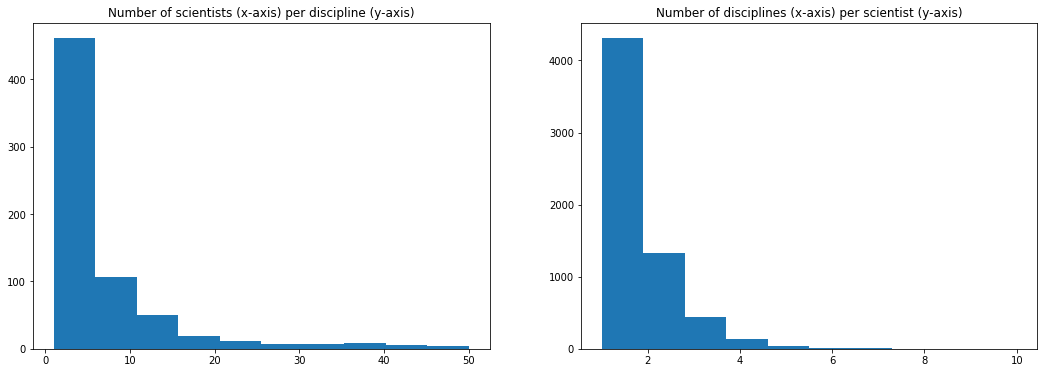

In [451]:
num_scientist_per_discipline = [discipline_df[col].sum() for col in discipline_df.columns[1:]]
num_disciplines_per_scientist = [np.sum(x[1:]) for x in discipline_df.values]

fig = plt.figure(figsize=(18,6))
fig.subplots(1,2)

plt.subplot(1,2,1)
plt.title("Number of scientists (x-axis) per discipline (y-axis)")
plt.hist(num_scientist_per_discipline, range=(1,50))

plt.subplot(1,2,2)
plt.title("Number of disciplines (x-axis) per scientist (y-axis)")
plt.hist(num_disciplines_per_scientist, range=(1,10))

plt.show()

# Link prediction with GraphSAGE algorithm

GraphSAGE is a GNN model that uses sampling and aggregation to create final node embeddings. It does this by selecting a set of neighbors of the target node and combining their features. This technique is applied to link prediction by adding a link classification layer to the node embeddings to obtain potential link embeddings, which are then used as input to a link classification layer to calculate the probability that a pair of nodes is linked on the existing network. The model is trained using the gradient descent algorithm, which adjusts the model's parameters to minimize cross entropy loss.

Import libraries, load data, create graph using Stellar graph library.

In [452]:
import networkx as nx
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

import stellargraph as sg
from stellargraph.data import EdgeSplitter, UniformRandomWalk, UnsupervisedSampler
from stellargraph.mapper import GraphSAGELinkGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, link_classification, MeanAggregator, LinkEmbedding

from sklearn import metrics
import random

from tensorflow import keras
import tensorflow as tf

%matplotlib inline

In [453]:
discipline_df.set_index('scientist_name', inplace=True)

display(discipline_df)
display(edge_df)

,Abstract algebra,Accelerator physics,Acoustics,Aerodynamics,Aerospace engineering,Agronomy,Algebra,Algebraic geometry,Algebraic graph theory,Algebraic number theory,...,Vision science,Visual perception,Volcanology,Wireless,Wireless network,Wireless sensor network,World War I,World Wide Web,X-ray crystallography,Zoology
scientist_name,,,,,,,,,,,,,,,,,,,,,
A. David Buckingham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A. J. Bernheim Brush,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A. Richard Newton,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A. Rod Gover,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A. Ronald Gallant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Émile Picard,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Étienne Biéler,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Éva Tardos,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,scientist_name1,scientist_name2
0,A. David Buckingham,John Pople
1,A. J. Bernheim Brush,Alan H. Borning
2,A. Richard Newton,Donald Pederson
3,A. Rod Gover,Michael Eastwood
4,A. Ronald Gallant,Wayne Fuller
...,...,...
4927,Émile Lemoine,Charles Adolphe Wurtz
4928,Étienne Biéler,James Chadwick
4929,Éva Tardos,András Frank
4930,Øystein Ore,Thoralf Skolem


In [454]:
G = sg.StellarGraph(
    nodes=discipline_df, edges=edge_df, source_column="scientist_name1", target_column="scientist_name2"
)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 6284, Edges: 4932

 Node types:
  default: [6284]
    Features: float32 vector, length 708
    Edge types: default-default->default

 Edge types:
    default-default->default: [4932]
        Weights: all 1 (default)
        Features: none


Before starting the prediction task, the original graph is divided into train, validation, and test graphs. Each of these graphs has the same number of nodes, but the number of edges is reduced because some positive links are removed from each graph and used as positive samples for training and testing.

In [455]:
# train, test, validation split
train_fraction = 0.2
test_fraction = 0.15
val_fraction = 0.2

Use the EdgeSplitter and from the original graph G obtain the reduced graph 

---

G_test with positive test edges removed. The reduced graph G_test with the test ground truth (dge_ids_test, edge_labels_test) will be used for testing/evaluating the model.

In [456]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.15 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=test_fraction, method="global", keep_connected=False, seed=2   # not enough edges to keep the graph connected 
)

** Sampled 739 positive and 739 negative edges. **


Use the EdgeSplitter and from the test graph G_test obtain the reduced graph G_val with positive test edges removed. The reduced graph G_val with the validation ground truth (dge_ids_val, edge_labels_val) will be used for tuning the model.

In [457]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_val = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.2 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_val with the sampled links removed:
G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=val_fraction, method="global", keep_connected=False, seed=2
)

** Sampled 838 positive and 838 negative edges. **


Use the EdgeSplitter and from the validation graph G_val obtain the reduced graph G_train with positive validation edges removed. The reduced graph G_train with the train ground truth (dge_ids_train, edge_labels_train) will be used for training the model. 

In [458]:
# Define an edge splitter on the reduced graph G_val:
edge_splitter_train = EdgeSplitter(G_val)

# Randomly sample a fraction p=0.2 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=train_fraction, method="global", keep_connected=False, seed=2
)

** Sampled 671 positive and 671 negative edges. **


Overview of the three graphs. Note that the number of nodes is the same for each graph.

In [459]:
print('=================== TRAIN GRAPH INFO ===================\n\n' + G_train.info() + '\n')
print('\n=================== VALID GRAPH INFO ===================\n\n' + G_val.info() + '\n')
print('\n=================== TEST GRAPH INFO ===================\n\n' + G_test.info() + '\n')

=================== TRAIN GRAPH INFO ===================

StellarGraph: Undirected multigraph
 Nodes: 6284, Edges: 2684

 Node types:
  default: [6284]
    Features: float32 vector, length 708
    Edge types: default-default->default

 Edge types:
    default-default->default: [2684]
        Weights: all 1 (default)
        Features: none


=================== VALID GRAPH INFO ===================

StellarGraph: Undirected multigraph
 Nodes: 6284, Edges: 3355

 Node types:
  default: [6284]
    Features: float32 vector, length 708
    Edge types: default-default->default

 Edge types:
    default-default->default: [3355]
        Weights: all 1 (default)
        Features: none


=================== TEST GRAPH INFO ===================

StellarGraph: Undirected multigraph
 Nodes: 6284, Edges: 4193

 Node types:
  default: [6284]
    Features: float32 vector, length 708
    Edge types: default-default->default

 Edge types:
    default-default->default: [4193]
        Weights: all 1 (defaul

Define the batch size and number of epochs for training the model. Finally, define the number of neighbors that GraphSAGE will sample at each layer. Here, we define a 2-layer GNN (1 and 2 hops away from the target node). At each layer GraphSAGE samples 8 neighbors.

In [460]:
batch_size = 50
epochs = 12  # The number of training epochs for training the GraphSAGE model.
num_samples = [8, 8] # number of layers/iterations in the GraphSAGE model.

GraphSAGE link generators are used to create training, validation and test links and fit them to the model. They sample node pairs at each layer (each hop) together with the corresponding labels (academic disciplines). The size of each GNN layer is 34 and has the same length with num_samples.

In [461]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
val_gen = GraphSAGELinkGenerator(G_val, batch_size, num_samples)
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)

train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)
val_flow = val_gen.flow(edge_ids_val, edge_labels_val)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

layer_sizes = [34, 34]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.25
)

In [462]:
x_inp, x_out = graphsage.in_out_tensors()

The final link classification layer takes a pair of node embeddings and applies a binary operator to output the final link embedding. The output is a binary classification that predicts the probability of two nodes to be connected.

In [463]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


The GNN layers together with the classification layer are stacked together to a Keras model. The unified neural network is trained using gradient descend with the RMSprop optimzer on a cross entropy loss function (since the problem is binary classification)

In [464]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.RMSprop(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=['acc'],
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [465]:
init_train_metrics = model.evaluate(train_flow)

init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

30/30 [==============================] - 2s 67ms/step - loss: 1.3549 - acc: 0.6083

Train Set Metrics of the initial (untrained) model:
	loss: 1.4700
	acc: 0.6349

Test Set Metrics of the initial (untrained) model:
	loss: 1.3549
	acc: 0.6083


Train the model

In [466]:
history = model.fit(train_flow, epochs=epochs, validation_data=val_flow, verbose=2)

Epoch 1/12
27/27 - 7s - loss: 0.9316 - acc: 0.5849 - val_loss: 0.6705 - val_acc: 0.6146 - 7s/epoch - 261ms/step
Epoch 2/12
27/27 - 5s - loss: 0.7163 - acc: 0.6416 - val_loss: 0.6434 - val_acc: 0.6504 - 5s/epoch - 194ms/step
Epoch 3/12
27/27 - 5s - loss: 0.6434 - acc: 0.6714 - val_loss: 0.6097 - val_acc: 0.6838 - 5s/epoch - 194ms/step
Epoch 4/12
27/27 - 5s - loss: 0.5878 - acc: 0.7221 - val_loss: 0.5741 - val_acc: 0.7124 - 5s/epoch - 195ms/step
Epoch 5/12
27/27 - 5s - loss: 0.5805 - acc: 0.7265 - val_loss: 0.5704 - val_acc: 0.7196 - 5s/epoch - 193ms/step
Epoch 6/12
27/27 - 5s - loss: 0.5353 - acc: 0.7496 - val_loss: 0.5625 - val_acc: 0.7315 - 5s/epoch - 196ms/step
Epoch 7/12
27/27 - 5s - loss: 0.5046 - acc: 0.7653 - val_loss: 0.5614 - val_acc: 0.7387 - 5s/epoch - 195ms/step
Epoch 8/12
27/27 - 5s - loss: 0.4906 - acc: 0.7802 - val_loss: 0.5806 - val_acc: 0.7339 - 5s/epoch - 171ms/step
Epoch 9/12
27/27 - 5s - loss: 0.4679 - acc: 0.8025 - val_loss: 0.5863 - val_acc: 0.7393 - 5s/epoch - 170

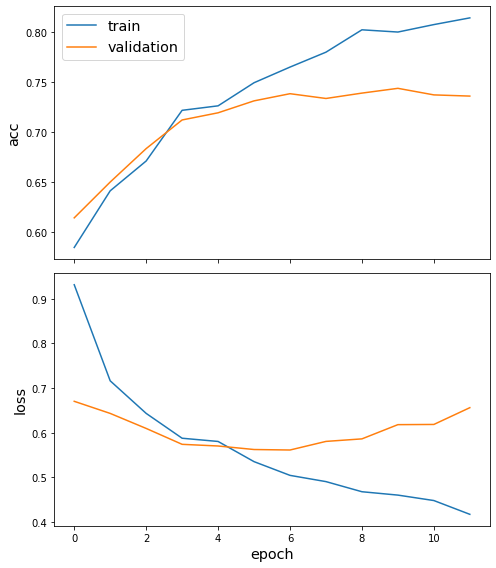

In [467]:
sg.utils.plot_history(history)

In [468]:
train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

30/30 [==============================] - 2s 66ms/step - loss: 0.6296 - acc: 0.7733

Train Set Metrics of the trained model:
	loss: 0.3626
	acc: 0.8808

Validation Set Metrics of the trained model:
	loss: 0.6541
	acc: 0.7381

Test Set Metrics of the trained model:
	loss: 0.6296
	acc: 0.7733
